In [ ]:
!pip install pyspark



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=e9cd4828c6cb598e0b91cc0edb594453925db0ac410f0eefac6ebf2a80fa5972
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Linear Regression Model").getOrCreate()

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import IndexToString, StringIndexer

In [ ]:
data = spark.read.csv('cruise_ship_info.csv',header = True, inferSchema = True)
data.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



<ipython-input-8-5e84c70be516>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = df.corr()


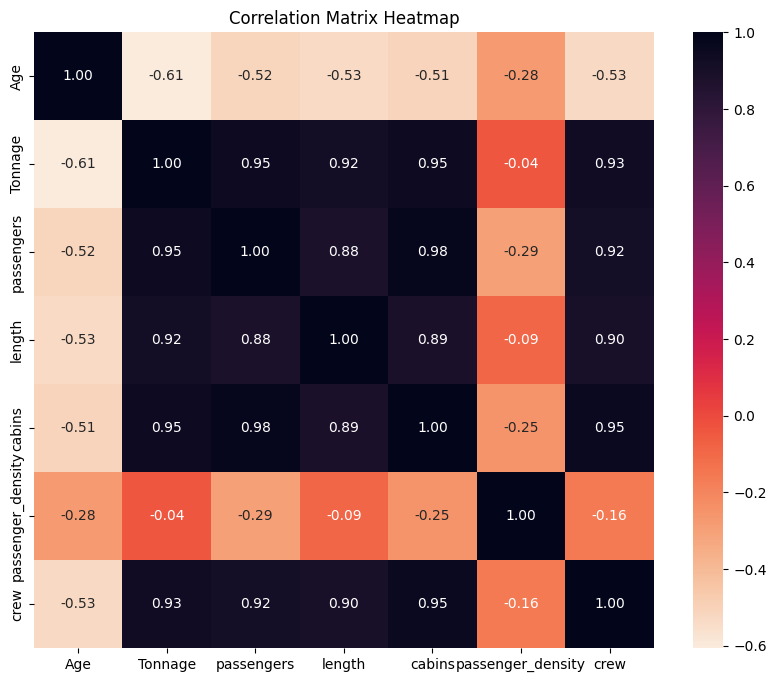

In [ ]:
df = data.toPandas()

corr_mat = df.corr()

numeric_cols = df.select_dtypes(include='number').columns

plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat,
            xticklabels=numeric_cols,
            yticklabels=numeric_cols,
            cmap='rocket_r',
            annot=True,
            fmt=".2f"
           )
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
data.head(3)



[Row(Ship_name='Journey', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55),
 Row(Ship_name='Quest', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55),
 Row(Ship_name='Celebration', Cruise_line='Carnival', Age=26, Tonnage=47.262, passengers=14.86, length=7.22, cabins=7.43, passenger_density=31.8, crew=6.7)]

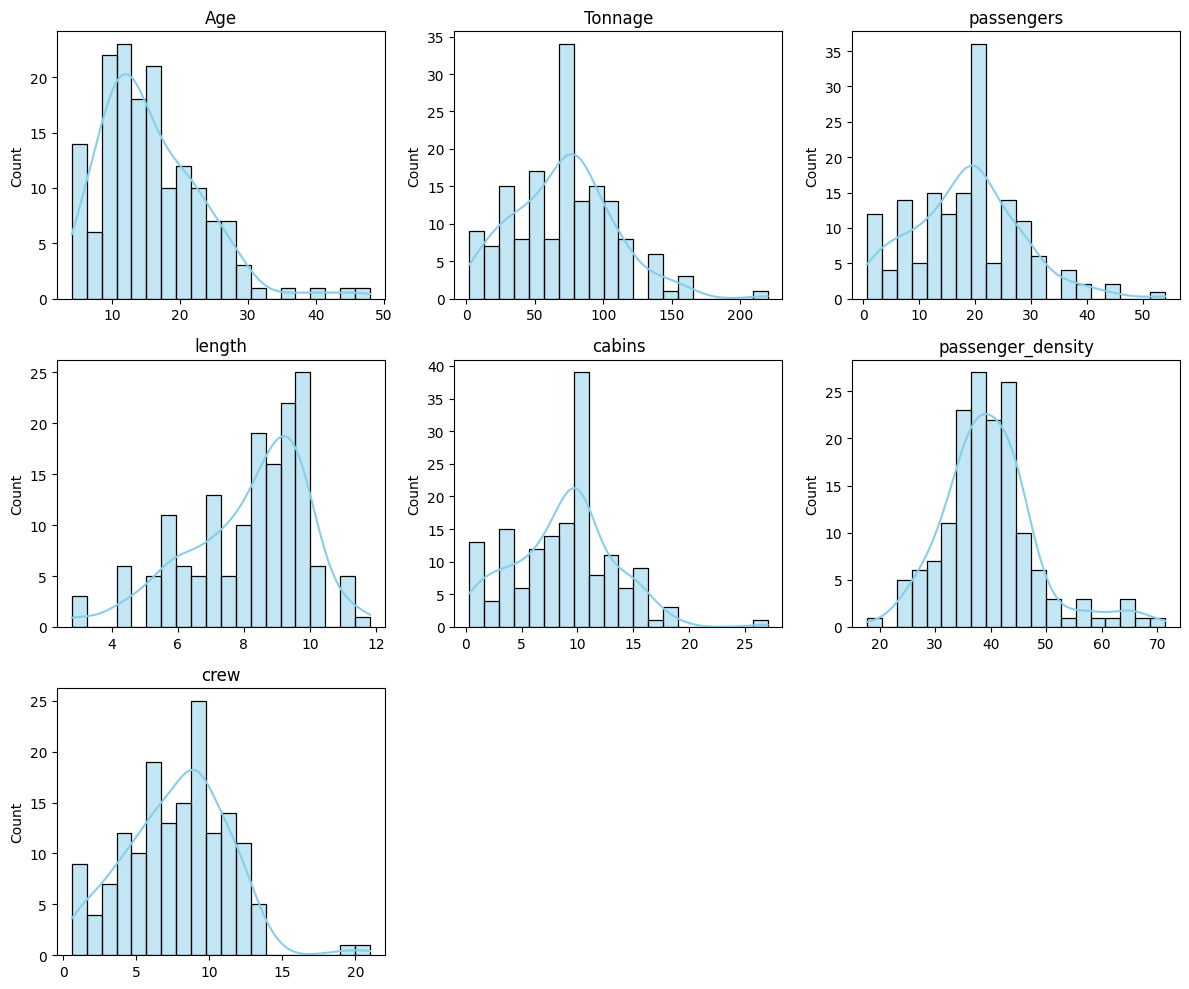

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = data.toPandas()

numeric_cols = df.select_dtypes(include='number').columns

plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, color='skyblue', bins=20)
    plt.title(col)
    plt.xlabel('')
plt.tight_layout()
plt.show()


In [ ]:
for item in data.head(1)[0]:
    print(item)

Journey
Azamara
6
30.276999999999997
6.94
5.94
3.55
42.64
3.55


In [ ]:
data.columns


['Ship_name',
 'Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew']

In [ ]:
data.groupBy('Cruise_line').count().show()


+-----------------+-----+
|      Cruise_line|count|
+-----------------+-----+
|            Costa|   11|
|              P&O|    6|
|           Cunard|    3|
|Regent_Seven_Seas|    5|
|              MSC|    8|
|         Carnival|   22|
|          Crystal|    2|
|           Orient|    1|
|         Princess|   17|
|        Silversea|    4|
|         Seabourn|    3|
| Holland_American|   14|
|         Windstar|    3|
|           Disney|    2|
|        Norwegian|   13|
|          Oceania|    3|
|          Azamara|    2|
|        Celebrity|   10|
|             Star|    6|
|  Royal_Caribbean|   23|
+-----------------+-----+



In [ ]:
data.groupBy('Ship_name').count().show()



+------------+-----+
|   Ship_name|count|
+------------+-----+
|       Virgo|    1|
|     Fortuna|    1|
|      Shadow|    1|
|     Empress|    1|
|        Wind|    2|
|    Paradise|    1|
|        Surf|    1|
|      Wonder|    1|
|       Magic|    1|
|    Symphony|    1|
|    Sinfonia|    1|
| Inspiration|    1|
|   Millenium|    1|
|    Solstice|    1|
|PrideofAloha|    1|
|     Majesty|    2|
|     Ventura|    1|
|   Romantica|    1|
|      Spirit|    4|
|       Oasis|    1|
+------------+-----+
only showing top 20 rows



In [ ]:
indexer = StringIndexer(inputCols=["Ship_name","Cruise_line"], outputCols=["Ship_name_Index","Cruise_line_Index"])
indexed = indexer.fit(data).transform(data)
indexed.show()


+-----------+-----------+---+------------------+----------+------+------+-----------------+----+---------------+-----------------+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|Ship_name_Index|Cruise_line_Index|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+---------------+-----------------+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|           64.0|             16.0|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|           98.0|             16.0|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|           27.0|              1.0|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|           31.0|              1.0|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|          

In [ ]:
indexed.printSchema()


root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)
 |-- Ship_name_Index: double (nullable = false)
 |-- Cruise_line_Index: double (nullable = false)



In [ ]:
indexed.columns


['Ship_name',
 'Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew',
 'Ship_name_Index',
 'Cruise_line_Index']

In [ ]:
assembler = VectorAssembler(inputCols =['Age','Tonnage','passengers','length', 'cabins', 'passenger_density', 'Ship_name_Index', 'Cruise_line_Index'],
                            outputCol='features')

In [ ]:
output = assembler.transform(indexed)
output.printSchema()


root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)
 |-- Ship_name_Index: double (nullable = false)
 |-- Cruise_line_Index: double (nullable = false)
 |-- features: vector (nullable = true)



In [ ]:
print(output.features)


Column<'features'>


In [ ]:
output.head(1)


[Row(Ship_name='Journey', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55, Ship_name_Index=64.0, Cruise_line_Index=16.0, features=DenseVector([6.0, 30.277, 6.94, 5.94, 3.55, 42.64, 64.0, 16.0]))]

In [ ]:
final_data = output.select('features','crew')
final_data.show()

+--------------------+----+
|            features|crew|
+--------------------+----+
|[6.0,30.276999999...|3.55|
|[6.0,30.276999999...|3.55|
|[26.0,47.262,14.8...| 6.7|
|[11.0,110.0,29.74...|19.1|
|[17.0,101.353,26....|10.0|
|[22.0,70.367,20.5...| 9.2|
|[15.0,70.367,20.5...| 9.2|
|[23.0,70.367,20.5...| 9.2|
|[19.0,70.367,20.5...| 9.2|
|[6.0,110.23899999...|11.5|
|[10.0,110.0,29.74...|11.6|
|[28.0,46.052,14.5...| 6.6|
|[18.0,70.367,20.5...| 9.2|
|[17.0,70.367,20.5...| 9.2|
|[11.0,86.0,21.24,...| 9.3|
|[8.0,110.0,29.74,...|11.6|
|[9.0,88.5,21.24,9...|10.3|
|[15.0,70.367,20.5...| 9.2|
|[12.0,88.5,21.24,...| 9.3|
|[20.0,70.367,20.5...| 9.2|
+--------------------+----+
only showing top 20 rows



In [ ]:
train_data,test_data = final_data.randomSplit([0.7,0.3])


In [ ]:
train_data.describe().show()


+-------+-----------------+
|summary|             crew|
+-------+-----------------+
|  count|              118|
|   mean|7.999830508474586|
| stddev|3.638067013533246|
|    min|             0.59|
|    max|             21.0|
+-------+-----------------+



In [ ]:
test_data.describe().show()


+-------+-----------------+
|summary|             crew|
+-------+-----------------+
|  count|               40|
|   mean|7.187499999999998|
| stddev|3.033207450191536|
|    min|              0.6|
|    max|             13.6|
+-------+-----------------+



In [ ]:
regressor = LinearRegression(labelCol='crew')
model = regressor.fit(train_data)

In [ ]:
pred_data = model.evaluate(test_data)
pred_data.residuals.show()


+--------------------+
|           residuals|
+--------------------+
| -1.1727938630989385|
| 0.24607288264438765|
|-0.32018930392145784|
|  1.8089286211121611|
|-0.30693997661087735|
|   -0.50704388015542|
| -0.5233651566497617|
|   0.925376445153347|
|  -0.410268299689335|
|  0.1932721695986369|
|0.007594007655110424|
|  0.7645523795736064|
| 0.35879012261945187|
| -0.8061215574316893|
|  0.4981456124666295|
|  0.4961281870187193|
| -1.7028608657976996|
|  0.5077462029110826|
|  0.4901565195161979|
| -0.8755723659786057|
+--------------------+
only showing top 20 rows



In [ ]:
pred_data.rootMeanSquaredError


0.7405005181249102

In [ ]:
pred_data.r2


0.9388717602951995

In [ ]:
pred_data.meanSquaredError


0.5483410173432606

In [ ]:
pred_data.meanAbsoluteError


0.6230998085911829

In [ ]:
from pyspark.sql import functions as f
data.select(f.corr('crew','passengers')).show()

+----------------------+
|corr(crew, passengers)|
+----------------------+
|    0.9152341306065384|
+----------------------+



In [ ]:
data.select(f.corr('crew','cabins')).show()


+------------------+
|corr(crew, cabins)|
+------------------+
|0.9508226063578497|
+------------------+



In [ ]:
unlabeled_data = test_data.select('features')
test_predictions = model.transform(unlabeled_data)
test_predictions.show()

+--------------------+-------------------+
|            features|         prediction|
+--------------------+-------------------+
|[5.0,86.0,21.04,9...|  9.172793863098939|
|[6.0,113.0,37.82,...| 11.753927117355612|
|[7.0,158.0,43.7,1...| 13.920189303921457|
|[10.0,46.0,7.0,6....| 2.6610713788878386|
|[10.0,58.825,15.6...|  7.306939976610877|
|[10.0,86.0,21.14,...|   9.70704388015542|
|[10.0,110.0,29.74...| 12.123365156649761|
|[11.0,90.0,22.4,9...| 10.074623554846653|
|[11.0,90.09,25.01...|  8.890268299689335|
|[12.0,2.329,0.94,...|0.40672783040136307|
|[12.0,42.0,14.8,7...|  6.792405992344889|
|[12.0,91.0,20.32,...|  9.225447620426394|
|[14.0,33.0,4.9,5....| 2.8812098773805483|
|[14.0,77.104,20.0...|   8.80612155743169|
|[15.0,70.367,20.5...|   8.70185438753337|
|[15.0,70.367,20.5...|   8.70387181298128|
|[15.0,78.491,24.3...|    8.3028608657977|
|[16.0,77.71300000...|  8.582253797088917|
|[17.0,70.367,20.5...|  8.709843480483801|
|[17.0,75.166,19.2...|  8.535572365978606|
+----------